In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import time

In [2]:
import fastNLP
from fastNLP.io.dataset_loader import CSVLoader
from fastNLP import Batch
from fastNLP import Vocabulary
from fastNLP import RandomSampler, SequentialSampler
from fastNLP.io.embed_loader import EmbedLoader

## Part1. Text classification using RNN with random word embedding
### 1. Hyperparameter

In [3]:
batch_size = 2
learning_rate = 0.001
num_epoch = 5
hidden_size = 128
dropout_rate = 0
bidirectional = 0
use_pretrain = 0
freeze_pretrain = 1
embed_path = 'data/glove.6B.300d.txt'
embedding_size = 300

loss_history = []
load_address = None
use_cuda = torch.cuda.is_available()
print("use_cuda: ", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

use_cuda:  True


### 2. data preprocess 

In [4]:
def get_word(x):
    if(x == ' '):
        return [' ']
    else:
        return x.lower().split()

def load_data(path, is_train = 0):
    loader = CSVLoader(sep='\t')
    dataset = loader.load(path)
    dataset.delete_field('SentenceId')
    dataset.delete_field('PhraseId')
    
    dataset.apply(lambda x: get_word(x['Phrase']), new_field_name = 'words', is_input = True)
    dataset.apply(lambda x: len(x['words']), new_field_name = "length", is_input = True)
    dataset.delete_field('Phrase')
    if(is_train):
        dataset.apply(lambda x: int(x['Sentiment']), new_field_name = "Sentiment")
        dataset.set_target('Sentiment')
    return dataset

In [5]:
# 1. get dataset
dataset = load_data('data/train.tsv', 1)
train_dataset, val_dataset = dataset.split(0.1)
test_dataset = load_data('data/test.tsv', 0)
print("train_dataset size: ", train_dataset.get_length())
print("val_dataset size: ", val_dataset.get_length())
print("test_dataset size: ", test_dataset.get_length())

train_dataset size:  140454
val_dataset size:  15606
test_dataset size:  66292


In [6]:
# 2. get vocabulary
if(use_pretrain):
    loader = EmbedLoader()
    pre_embed, vocab = loader.load_without_vocab(embed_path, normalize = False)
    embeddig_size = pre_embed.shape[1]
else:
    vocab = Vocabulary(min_freq=2).from_dataset(dataset, field_name='words')
print("vocabulary size: ", len(vocab))

vocabulary size:  16507


In [7]:
# 3. change word to index
vocab.index_dataset(train_dataset, field_name='words',new_field_name='words')
vocab.index_dataset(val_dataset, field_name='words',new_field_name='words')
vocab.index_dataset(test_dataset, field_name='words',new_field_name='words')

### 3. Build RNN model

In [9]:
def bi_fetch(rnn_outs):
    # rnn_out: [batch_size, seq_len, 2 * hidden_size]
    batch_size = rnn_outs.size(0)
    seq_len = rnn_outs.size(1)
    rnn_outs = rnn_outs.view(batch_size, seq_len, 2, -1) # (batch_size, seq_len, 2, hidden_size)

    fw_out = torch.index_select(rnn_outs, 2, Variable(torch.LongTensor([0])).to(device))
    fw_out = fw_out.view(batch_size * seq_len, -1) # 正向
    bw_out = torch.index_select(rnn_outs, 2, Variable(torch.LongTensor([1])).to(device))
    bw_out = bw_out.view(batch_size * seq_len, -1)

    batch_range = Variable(torch.LongTensor(range(batch_size))).to(device) * seq_len

    fw_index = batch_range + seq_len - 1
    fw_out = torch.index_select(fw_out, 0, fw_index)  # (batch_size, hid)
    bw_index = batch_range
    bw_out = torch.index_select(bw_out, 0, bw_index)
    outs = torch.cat([fw_out, bw_out], dim=1)

    return outs

In [27]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx = vocab['<pad>'])# nn.Embedding用的是N(0,1)的随机初始化
        if(use_pretrain):
            self.embedding.from_pretrained(torch.Tensor(pre_embed), freeze = bool(freeze_pretrain))
        self.LSTM = nn.LSTM(embedding_size, hidden_size, batch_first=True, dropout = dropout_rate, bidirectional = bool(bidirectional))
        h = hidden_size + hidden_size * bidirectional
        self.classifier = nn.Sequential(
            nn.Linear(h, 5)
        )

    def forward(self, x, lengths):
        N = x.size(0)
        x = self.embedding(x)
        x = pack_padded_sequence(x, lengths, batch_first=True) # 去掉所有padding, [N, T, E] -> [N * T, E]
        # 加双向
        out, (ht, ct) = self.LSTM(x)
        if(bidirectional):
            out = pad_packed_sequence(out, batch_first = True)[0]
            x = bi_fetch(out)
        else:
            x = ht
        score = self.classifier(x.view(N, -1))
        return score
    
model = RNN()
# model = nn.DataParallel(model)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
if(load_address is not None):
    model = torch.load(load_address)

In [11]:
print(model.named_modules)

<bound method Module.named_modules of RNN(
  (embedding): Embedding(16507, 300, padding_idx=0)
  (LSTM): LSTM(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=5, bias=True)
  )
)>


### 4. Train Model

In [12]:
def model_status(training):
    if(training):
        return 'model is in training'
    else:
        return 'model is in testing'

In [13]:
def pack(batch_x, batch_y, is_train = 1):
    x = batch_x['words']
    lengths = batch_x['length']
    index = torch.argsort(lengths, descending = True)
    x = x[index].to(device)
    lengths = lengths[index].to(device)
    if(is_train):
        y = batch_y['Sentiment']
        y = y[index].to(device)
        return x, lengths, y
    else:
        return x, lengths

In [14]:
def predict(model, dataset):
    model.eval()
    print(model_status(model.training))
    num_correct = torch.tensor(0.0)
    num_sample = torch.tensor(0.0)
    for batch_x, batch_y in Batch(dataset, sampler = SequentialSampler(), batch_size = batch_size):
        x, lengths, y = pack(batch_x, batch_y)
        score = model(x, lengths)
        y_predict = torch.argmax(score, dim = 1)
        num_correct += torch.sum(y_predict == y)
        num_sample += x.shape[0]
    return 1.0 * num_correct / num_sample

In [28]:
def train(model, dataset, optimizer, num_epoch = 30):
    loss_history = []
    for i in range(num_epoch):
        start = time.time()
        print("Epoch: {0} start".format(i))
        model.train()
        print(model_status(model.training))
        losses = 0
        for batch_x, batch_y in Batch(dataset, sampler = RandomSampler(), batch_size = batch_size):
            x, lengths, y = pack(batch_x, batch_y)
            optimizer.zero_grad()
            score = model(x, lengths)
            loss_fn = nn.CrossEntropyLoss().to(device)
            loss = loss_fn(score, y)
            loss.backward()
            losses += loss
            optimizer.step()
        end = time.time()
        print("Epoch: {0} finish".format(i))
        loss_history.append(losses)
        acc = predict(model, val_dataset[0:100])
        print("Epoch: {0}, loss: {1}, accu: {2}, time: {3}".format(i, losses, acc, end - start))
    return loss_history

loss_history_new = train(model, train_dataset[0:500], optimizer, num_epoch = 10)

Epoch: 0 start
model is in training
Epoch: 0 finish
model is in testing
Epoch: 0, loss: 358.6976013183594, accu: 0.46000000834465027, time: 3.368295907974243
Epoch: 1 start
model is in training
Epoch: 1 finish
model is in testing
Epoch: 1, loss: 202.03274536132812, accu: 0.3499999940395355, time: 3.7628448009490967
Epoch: 2 start
model is in training
Epoch: 2 finish
model is in testing
Epoch: 2, loss: 58.00729751586914, accu: 0.33000001311302185, time: 3.426038980484009
Epoch: 3 start
model is in training
Epoch: 3 finish
model is in testing
Epoch: 3, loss: 14.02380084991455, accu: 0.3799999952316284, time: 4.003709316253662
Epoch: 4 start
model is in training
Epoch: 4 finish
model is in testing
Epoch: 4, loss: 4.151238441467285, accu: 0.4000000059604645, time: 4.006706953048706
Epoch: 5 start
model is in training
Epoch: 5 finish
model is in testing
Epoch: 5, loss: 2.1997342109680176, accu: 0.3799999952316284, time: 3.854795455932617
Epoch: 6 start
model is in training
Epoch: 6 finish
m

### 5. Get Result

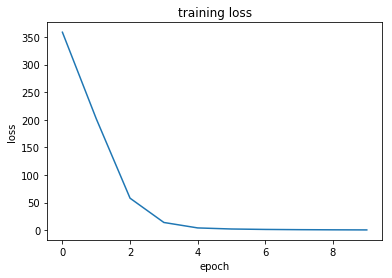

In [29]:
def plot(plt):
    plt.title("training loss")
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.plot(range(len(loss_history)), loss_history)
    return plt

loss_history += loss_history_new
plt.figure(0)
plot(plt)
plt.show()

In [30]:
def get_answer(model, dataset):
    answer = []
    model.eval()
    print("start to generate result")
    print(model_status(model.training))
    for batch_x, batch_y in Batch(dataset, sampler = SequentialSampler(), batch_size = batch_size):
        x, lengths = pack(batch_x, batch_y, 0)
        score = model(x, lengths)
        y_predict = torch.argmax(score, dim = 1).cpu().numpy()
        answer += list(y_predict)
    index = [a + 156061 for a in range(len(answer))]
    dataframe = pd.DataFrame({'PhraseId':index, 'Sentiment':answer})
    name = "result/RNN_pretrain" + str(use_pretrain) + "_freeze" + str(freeze_pretrain) + "_random_batch_size" + str(batch_size) + "_dropout" + str(dropout_rate) + "_bidirectional" + str(bidirectional) + "_lr" + str(learning_rate) + "_epoch" + str(num_epoch) + "_embedding" + str(embedding_size)+".csv"
    dataframe.to_csv(name,index=False,sep=',')
    return answer

answer = get_answer(model, test_dataset[0:10])

start to generate result
model is in testing
